In [1]:
# Created on jan 2025
# https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1012692

# numpy and scipy
import numpy as np
import scipy.stats as stt
import scipy.linalg as spl
import scipy.signal as spsg
import scipy.io as sio


# MOU model
from test_MOU_largenet import MOUv2

# classification scikit-learn
import sklearn.linear_model as skllm
import sklearn.preprocessing as skppr
import sklearn.pipeline as skppl
import sklearn.neighbors as sklnn

# plotting
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sb
import pandas as pd

#saving results
import os


# Empirical data

In [2]:
data_dir = './' # data repo
res_dir = './results/' # results
os.makedirs(res_dir, exist_ok=True)
graph_format = 'png' # graph formatting


# data and model parameters
#subjects = [3, 4, 5, 6, 7, 11, 16, 17, 18, 20, 21, 26, 27, 29, 30]
subjects = [3, 4, 5, 7, 11, 16, 17, 18, 20, 21, 26, 27, 29, 30]
n_sub = 48
#Change
conds = ['CTR', 'SCZ']
n_cond = len(conds) # number of conditions

N = 68 # size of network for AAL90


In [3]:
TS_CTR  = np.load('./TS_Control.npy')
TS_SCZ  = np.load('./TS_Schizo.npy')



In [4]:
condition_0 = TS_CTR[:, 0:68, :] 
condition_0.shape 

(116, 68, 152)

In [5]:

# Example input array of shape (180, 718, 36)
#original_array = TS

# Separate the participants by condition
condition_0 = TS_CTR[0:48, 0:68, :]  # all participants (condition 0)
condition_1 = TS_SCZ[:, 0:68, :]  # Last 48 participants (condition 1)

# Determine the maximum number of participants in either condition (for alignment)
max_participants = max(condition_0.shape[2], condition_1.shape[2])

# Pad the smaller group to match the size of the larger one along the participant dimension
condition_0_padded = np.pad(condition_0, ((0, 0), (0, 0), (0, max_participants - condition_0.shape[2])), mode='constant')
condition_1_padded = np.pad(condition_1, ((0, 0), (0, 0), (0, max_participants - condition_1.shape[2])), mode='constant')

# Stack the conditions along the fourth dimension
new_array = np.stack((condition_0_padded, condition_1_padded), axis=3)

print("New array shape:", new_array.shape)

New array shape: (48, 68, 152, 2)


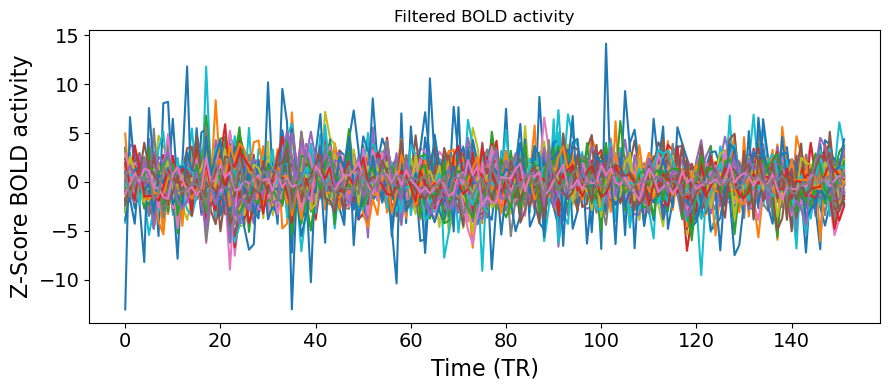

In [6]:
#All data plotted are stored in new_array
plt.figure(figsize=(9,4))
plt.plot(range(new_array.shape[2]), new_array[1,:,:,1].T)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Time (TR)', fontsize=16)
plt.ylabel('Z-Score BOLD activity', fontsize=16)
plt.title("Filtered BOLD activity")
plt.tight_layout()

Text(0.5, 1.0, 'FC0')

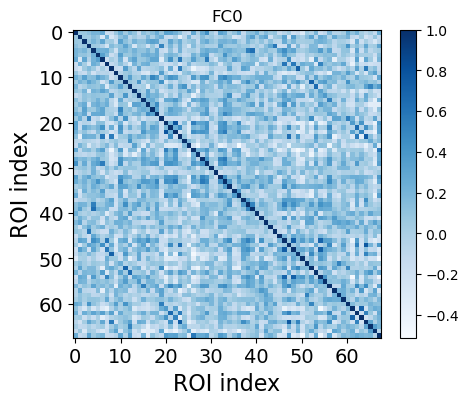

In [7]:
FC0 = np.corrcoef(new_array[1,:,:,1]) 
FC1 = FC0/np.max(FC0)
plt.figure(figsize=(5,4))
plt.imshow(FC1, cmap='Blues')
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('ROI index', fontsize=16)
plt.ylabel('ROI index', fontsize=16)
plt.title("FC0")

# Functional Mask

In [8]:
# create topological mask for AAL90
N=68
FC0 = np.corrcoef(new_array[44,:,:,1]) 
FC1 = FC0/np.max(FC0)
lim_FC = 0.1 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[FC1>lim_FC] = True
for i in range(N):
    mask_EC[i,i] = False # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0


network size: 68
EC density: 0.36259877085162423


## Connectome mask

Use a high trashold for the Conectome and use an Or to combine Functional and Structural. Just to get the connectome playing a role.

In [16]:
# create topological mask for AAL90

SCR = sio.loadmat('./SC_EnigmadK68.mat')['matrix']
SC=SCR/np.max(SCR)
lim_SC = 0.7 # limit DTI value to determine SC (only connections with larger values are tuned)
# anatomy-derived mask for existing connections for EC
mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
mask_EC[SC>lim_SC] = True
for i in range(N):
    mask_EC[i,i] = False # no self connection
    mask_EC[i,N-1-i] = True # additional interhemispherical connections
print('network size:', N)
print('EC density:', mask_EC.sum()/float(N*(N-1)))

# diagonal mask for input noise matrix (so far, tune noise matrix for diagonal elements only)
mask_Sigma = np.eye(N,dtype=bool)
regul_Sigma = 0.0



network size: 68
EC density: 0.10623353819139596


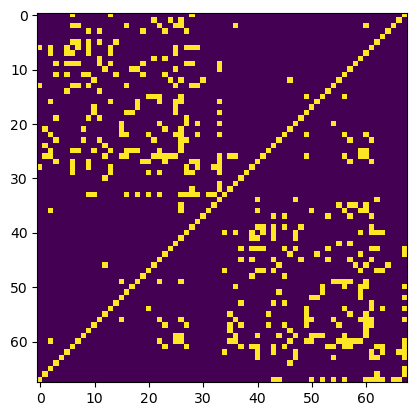

In [17]:
plt.imshow(mask_EC)

In [11]:
SC = sio.loadmat('./SC_EnigmadK68.mat')

In [12]:
SC = sio.loadmat('./SC_EnigmadK68.mat')['matrix']

# MOU fitting to fMRI data

In [531]:
'''
#Define the mask FC0 percentage:
#Range of interest [0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3]
lim_FC = 0.1 # limit DTI value to determine FC0 mask (only connections with larger values are tuned)
'''

'\n#Define the mask FC0 percentage:\n#Range of interest [0.02, 0.05, 0.07, 0.1, 0.15, 0.2, 0.3]\nlim_FC = 0.1 # limit DTI value to determine FC0 mask (only connections with larger values are tuned)\n'

11 1
19 0
46 1

In [532]:
lim_FC = np.full((48, 2), 0.1)

#outliers
lim_FC[11, 1] = 0.05
lim_FC[19, 0] = 0.05
#good changes
lim_FC[24, 1] = 0.2
lim_FC[25, 1] = 0.2
lim_FC[19, 1] = 0.2
lim_FC[46, 0] = 0.2
lim_FC[11, 0] = 0.3
lim_FC[16, 1] = 0.3
lim_FC[46, 0] = 0.3

lim_FC[46, 1] = 0.2


In [533]:
#using new_array where all data are stored: 

min_val_EC = 0. # minimal value for EC
max_val_EC = 1. # maximal value for EC
min_val_Sigma = 0. # minimal value for Sigma

n_sub=48
n_cond=2
N=68
# arrays to store results
var_BOLD = np.zeros([n_sub,n_cond,N]) # empirical BOLD variance
J_mod = np.zeros([n_sub,n_cond,N,N]) # model Jacobian (EC.) In the article of Entropy production B=-J
Sigma_mod = np.zeros([n_sub,n_cond,N,N]) # model sigma. In the article of Entropy production sigma=2D
FC0_mod = np.zeros([n_sub,n_cond,N,N]) # model zero-lad FC
err_mod = np.zeros([n_sub,n_cond]) # model error
fit_mod = np.zeros([n_sub,n_cond]) # model goodness of fit (Pearson corr)


# loop over subject and conditions
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        # get time series
        ts = new_array[i_sub,:,:,i_cond]
        # store empirical BOLD variance (48, 68, 152, 2)
        var_BOLD[i_sub,i_cond,:] = ts.var(axis=1)
        FC0 = np.corrcoef(new_array[i_sub,:,:,i_cond]) 
        FC1 = FC0/np.max(FC0)
        mask_EC = np.zeros([N,N],dtype=bool) # EC weights to tune
        mask_EC[FC1>lim_FC[i_sub, i_cond]] = True
        for i in range(N):
            mask_EC[i,i] = False # no self connection
            mask_EC[i,N-1-i] = True # additional interhemispherical connections
 
        # invert model
        mou_est = MOUv2()
        mou_est.fit(ts.T, mask_C=mask_EC, mask_Sigma=mask_Sigma, algo_version='true', min_iter=20, epsilon_C=0.005, epsilon_Sigma=0.005) #, verbose=True)

        # store results
        J_mod[i_sub,i_cond,:,:] = mou_est.J
        Sigma_mod[i_sub,i_cond,:,:] = mou_est.Sigma
        FC0_mod[i_sub,i_cond,:,:] = spl.solve_lyapunov(J_mod[i_sub,i_cond,:,:].T, -Sigma_mod[i_sub,i_cond,:,:])
        err_mod[i_sub,i_cond] = mou_est.d_fit['distance']
        fit_mod[i_sub,i_cond] = mou_est.d_fit['correlation']

        print('sub', i_sub, '; cond', i_cond, ':', mou_est.d_fit)



sub 0 ; cond 0 : {'n_tau': 2, 'iterations': 95, 'distance': np.float64(0.7661432834911104), 'correlation': np.float64(0.735406777537547), 'distance history': array([0.91027644, 0.90788178, 0.90552969, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.42523869, 0.43323628, 0.44106712, ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.7248400507908922), 'distFC1': np.float64(0.8075789347682952)}
sub 0 ; cond 1 : {'n_tau': 2, 'iterations': 35, 'distance': np.float64(0.8114780800589657), 'correlation': np.float64(0.6566428382782753), 'distance history': array([0.89350402, 0.88902935, 0.88523676, ..., 0.        , 0.        ,
       0.        ]), 'correlation history': array([0.40505704, 0.43514997, 0.4621871 , ..., 0.        , 0.        ,
       0.        ]), 'distFC0': np.float64(0.6990544107283141), 'distFC1': np.float64(0.9242423689314986)}
sub 1 ; cond 0 : {'n_tau': 2, 'iterations': 70, 'distance': np.float64(0.8183950522320937), '

In [534]:
n_sub


48

In [535]:
fit_mod

array([[0.73540678, 0.65664284],
       [0.64314556, 0.61596936],
       [0.7599316 , 0.66804102],
       [0.69855032, 0.67716129],
       [0.68685891, 0.62388074],
       [0.66706815, 0.7220409 ],
       [0.67435173, 0.71241189],
       [0.74458594, 0.70081543],
       [0.61021342, 0.62102525],
       [0.68960326, 0.60771761],
       [0.66719535, 0.67108484],
       [0.6174334 , 0.34470636],
       [0.67951743, 0.64034615],
       [0.69340594, 0.7485209 ],
       [0.75614647, 0.70431356],
       [0.72251103, 0.60151538],
       [0.71074406, 0.72717315],
       [0.72821156, 0.65573839],
       [0.70319085, 0.67403137],
       [0.54181779, 0.72948983],
       [0.69204132, 0.71917942],
       [0.68566237, 0.62083035],
       [0.70240105, 0.68719498],
       [0.77642185, 0.6870239 ],
       [0.61158125, 0.63769429],
       [0.70190738, 0.60076812],
       [0.62416547, 0.71631027],
       [0.67644417, 0.71985899],
       [0.67532384, 0.6479491 ],
       [0.71205654, 0.64882223],
       [0.

In [553]:
for i_sub in range(n_sub):
    for i_cond in range(n_cond):
        if fit_mod[i_sub,i_cond]< 0.59:
            print(i_sub, i_cond)

11 1
19 0


In [537]:
#%% save results
np.save(os.path.join(res_dir, f'J_mod_try.npy'), J_mod)
np.save(os.path.join(res_dir, f'Sigma_mod_try.npy'), Sigma_mod)
np.save(os.path.join(res_dir, f'FC0_mod_try.npy'), FC0_mod)

np.save(os.path.join(res_dir, f'err_mod_try.npy'), err_mod)
np.save(os.path.join(res_dir, f'fit_mod_try.npy'), fit_mod)

np.save(os.path.join(res_dir, f'var_BOLD_try.npy'), var_BOLD)


In [538]:
print("Files in results directory:", os.listdir(res_dir))


Files in results directory: ['entropy_prod_rate_0.17.eps', 'model_fit_error_0.17.eps', 'FC0_mod_0.2.npy', 'FC0_mod_0.1.npy', 'J_mod_0.5.npy', 'FC0_mod_0.17.npy', 'fit_mod_0.1.npy', 'err_mod_0.1.npy', 'J_mod_0.15.npy', 'model_fit_error_0.1.eps', 'Sigma_mod_0.3.npy', 'EPR_0.0.npy', 'model_fit_error_0.05.eps', 'Sigma_mod_0.17.npy', 'Sigma_mod_0.12.npy', 'EPR_0.05.npy', 'example_EC_0.17.eps', 'EPR_0.12.npy', 'example0_EC_0.07.eps', 'FC0_mod_0.12.npy', 'EPR_try.npy', 'example0_EC_0.05.eps', 'Sigma_mod_0.07.npy', 'err_mod_0.0.npy', 'err_mod_0.05.npy', 'fit_mod_0.15.npy', 'model_fit_error_0.3.eps', 'model_fit_error_0.0.eps', 'example_EC_0.5.eps', 'example0_EC_0.5.eps', 'J_mod_0.3.npy', 'model_goodness_fit_0.17.eps', 'EPR.npy', 'fit_mod_0.2.npy', 'err_mod_0.15.npy', 'model_goodness_fit.eps', 'var_BOLD_0.05.npy', 'var_BOLD_0.15.npy', 'entropy_prod_rate_0.12.eps', 'entropy_prod_rate_0.0.eps', 'example_EC_0.1.eps', 'entropy_prod_rate_0.2.eps', 'Sigma_mod_0.0.npy', 'fit_mod_0.12.npy', 'err_mod_0.3

In [539]:
print("Saving results in:", os.path.abspath(res_dir))


Saving results in: /home/angelica/Desktop/EntropyProduction_MOUProcess/results


## Test goodness of fit

/tmp/ipykernel_5156/3700854878.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_5156/3700854878.py:15: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_5156/3700854878.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
/tmp/ipykernel_5156/3700854878.py:38: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)


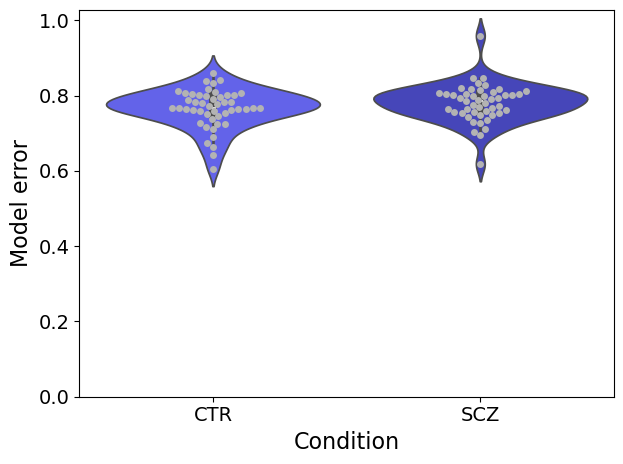

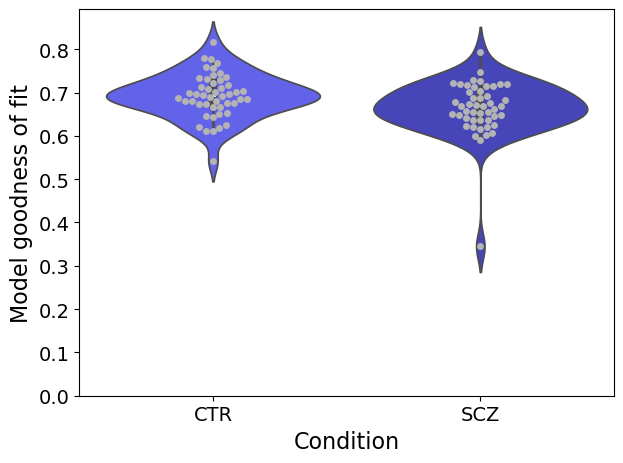

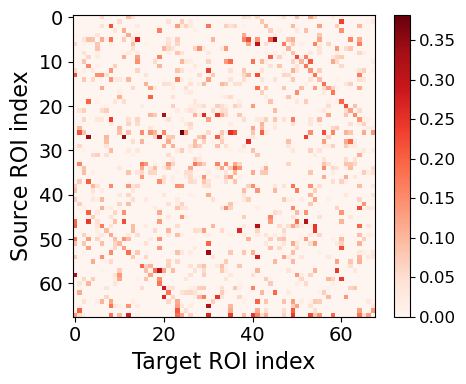

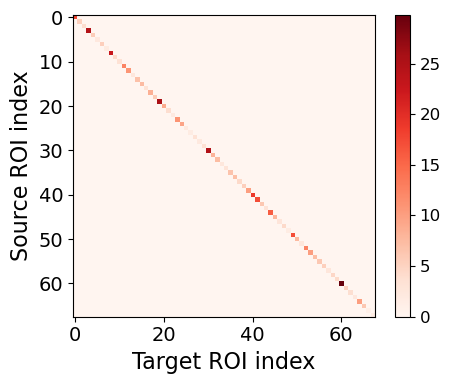

In [540]:
mask_diag = np.eye(N, dtype=bool) # mask for diagonal elements

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]] # colors

# model error

err_mod_tmp = dict()
err_mod_tmp['sum EC'] = err_mod.flatten()
err_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
err_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

err_mod_df = pd.DataFrame(err_mod_tmp)

plt.figure()
sb.violinplot(data=err_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=err_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model error',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_fit_error_try.eps'), format='eps')


# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)

plt.figure()
sb.violinplot(data=fit_mod_df, x='cond', y='sum EC', palette=cols)
sb.swarmplot(data=fit_mod_df, x='cond', y='sum EC', color=[0.7,0.7,0.7])
plt.axis(ymin=0)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Condition',fontsize=16)
plt.ylabel('Model goodness of fit',fontsize=16)

plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'model_goodness_fit_try.eps'), format='eps')


# Example EC

plt.figure(figsize=(5,4))
plt.imshow(np.maximum(J_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
#plt.imshow(J_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example0_EC_try.eps'), format='eps')#Change

# Example EC

plt.figure(figsize=(5,4))
#plt.imshow(np.maximum(Sigma_mod[0,0,:,:],0), cmap='Reds')   # Show only the non-negatives
plt.imshow(Sigma_mod[0,0,:,:], cmap='Reds')   # Show only the non-negatives
plt.colorbar()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Target ROI index', fontsize=16)
plt.ylabel('Source ROI index', fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(res_dir,f'example_EC_try.eps'), format='eps')

# 


In [541]:
print("Files in results directory:", os.listdir(res_dir))


Files in results directory: ['entropy_prod_rate_0.17.eps', 'model_fit_error_0.17.eps', 'FC0_mod_0.2.npy', 'FC0_mod_0.1.npy', 'J_mod_0.5.npy', 'FC0_mod_0.17.npy', 'fit_mod_0.1.npy', 'err_mod_0.1.npy', 'J_mod_0.15.npy', 'model_fit_error_0.1.eps', 'Sigma_mod_0.3.npy', 'EPR_0.0.npy', 'model_fit_error_0.05.eps', 'Sigma_mod_0.17.npy', 'Sigma_mod_0.12.npy', 'EPR_0.05.npy', 'example_EC_0.17.eps', 'EPR_0.12.npy', 'example0_EC_0.07.eps', 'FC0_mod_0.12.npy', 'EPR_try.npy', 'example0_EC_0.05.eps', 'Sigma_mod_0.07.npy', 'err_mod_0.0.npy', 'err_mod_0.05.npy', 'fit_mod_0.15.npy', 'model_fit_error_0.3.eps', 'model_fit_error_0.0.eps', 'example_EC_0.5.eps', 'example0_EC_0.5.eps', 'J_mod_0.3.npy', 'model_goodness_fit_0.17.eps', 'EPR.npy', 'fit_mod_0.2.npy', 'err_mod_0.15.npy', 'model_goodness_fit.eps', 'var_BOLD_0.05.npy', 'var_BOLD_0.15.npy', 'entropy_prod_rate_0.12.eps', 'entropy_prod_rate_0.0.eps', 'example_EC_0.1.eps', 'entropy_prod_rate_0.2.eps', 'Sigma_mod_0.0.npy', 'fit_mod_0.12.npy', 'err_mod_0.3

In [542]:
# Pearson correlation

fit_mod_tmp = dict()
fit_mod_tmp['sum EC'] = fit_mod.flatten()
fit_mod_tmp['sub'] = np.repeat(np.arange(n_sub), n_cond).flatten()
fit_mod_tmp['cond'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()

fit_mod_df = pd.DataFrame(fit_mod_tmp)



# Calculate Entropy Production of the fitted MOU

In [543]:
# transpose to Saclay's framework
EPR = np.zeros([n_sub,n_cond])
Q_indiv = np.zeros([n_sub,n_cond,N,N])

for i_sub in range(n_sub):
    for i_cond in range(n_cond):

        try:
            B = np.copy(-J_mod[i_sub,i_cond,:,:].T) # B=-J
            D = np.copy(0.5 * Sigma_mod[i_sub,i_cond,:,:]) # D=1/2 * Sigma
            S = np.copy(FC0_mod[i_sub,i_cond,:,:])
            
            Q = np.dot(B, S) - D
            Q_indiv[i_sub,i_cond,:,:] = Q
            
            # sanity check
            if True:
                print('should be close to zero:', np.abs(np.dot(B,S) + np.dot(S,B.T) -2*D).max())
            
            # formula from Godreche Luck
            Dinv = np.linalg.pinv(D)
            Sinv = np.linalg.pinv(S)
            
            entropy_prod_rate = -np.trace(np.dot(np.dot(np.dot(Sinv, Q), Dinv), Q))  #-tr(S^(-1)*Q*D^(-1)*Q)
            EPR[i_sub,i_cond] = entropy_prod_rate

        except:
            print('problem with subject/cond:', i_sub, i_cond)
       

np.save(os.path.join(res_dir, f'EPR_try.npy'),EPR)



should be close to zero: 1.1013412404281553e-13
should be close to zero: 1.0658141036401503e-13
should be close to zero: 1.1368683772161603e-13
should be close to zero: 2.2737367544323206e-13
should be close to zero: 2.7000623958883807e-13
should be close to zero: 1.4921397450962104e-13
should be close to zero: 7.105427357601002e-14
should be close to zero: 2.2737367544323206e-13
should be close to zero: 1.7053025658242404e-13
should be close to zero: 4.8031023602845835e-14
should be close to zero: 2.3447910280083306e-13
should be close to zero: 3.552713678800501e-13
should be close to zero: 3.268496584496461e-13
should be close to zero: 1.7053025658242404e-13
should be close to zero: 1.3677947663381929e-13
should be close to zero: 6.142308883738679e-14
should be close to zero: 3.979039320256561e-13
should be close to zero: 3.694822225952521e-13
should be close to zero: 5.5067062021407764e-14
should be close to zero: 2.2294666113253925e-13
should be close to zero: 1.4210854715202004e-1

## TO DO LIST

Get X per partecipant and condition
Compare the trace of X with N 
Sum the values of the the rows of the matrix X you get a vector, if you see how far each component of the vector is from 1 characterized to far of equilibrium.
1. Matrix X 
1.b Check if it is symmetric
2. Verctor for brain region (rows and columns)
3. Store the vectors in a matrix for each condition (68x48)

In [544]:
print("Files in results directory:", os.listdir(res_dir))


Files in results directory: ['entropy_prod_rate_0.17.eps', 'model_fit_error_0.17.eps', 'FC0_mod_0.2.npy', 'FC0_mod_0.1.npy', 'J_mod_0.5.npy', 'FC0_mod_0.17.npy', 'fit_mod_0.1.npy', 'err_mod_0.1.npy', 'J_mod_0.15.npy', 'model_fit_error_0.1.eps', 'Sigma_mod_0.3.npy', 'EPR_0.0.npy', 'model_fit_error_0.05.eps', 'Sigma_mod_0.17.npy', 'Sigma_mod_0.12.npy', 'EPR_0.05.npy', 'example_EC_0.17.eps', 'EPR_0.12.npy', 'example0_EC_0.07.eps', 'FC0_mod_0.12.npy', 'EPR_try.npy', 'example0_EC_0.05.eps', 'Sigma_mod_0.07.npy', 'err_mod_0.0.npy', 'err_mod_0.05.npy', 'fit_mod_0.15.npy', 'model_fit_error_0.3.eps', 'model_fit_error_0.0.eps', 'example_EC_0.5.eps', 'example0_EC_0.5.eps', 'J_mod_0.3.npy', 'model_goodness_fit_0.17.eps', 'EPR.npy', 'fit_mod_0.2.npy', 'err_mod_0.15.npy', 'model_goodness_fit.eps', 'var_BOLD_0.05.npy', 'var_BOLD_0.15.npy', 'entropy_prod_rate_0.12.eps', 'entropy_prod_rate_0.0.eps', 'example_EC_0.1.eps', 'entropy_prod_rate_0.2.eps', 'Sigma_mod_0.0.npy', 'fit_mod_0.12.npy', 'err_mod_0.3

In [545]:
print("Saving results in:", os.path.abspath(res_dir))


Saving results in: /home/angelica/Desktop/EntropyProduction_MOUProcess/results


/tmp/ipykernel_5156/1984700097.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
/tmp/ipykernel_5156/1984700097.py:22: UserWarning: The palette list has more values (4) than needed (2), which may not be intended.
  ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)


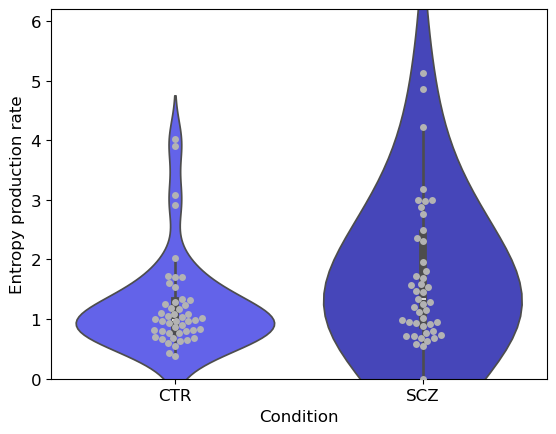

In [546]:
#%% plots

matplotlib.rc('font', size=12) 
matplotlib.rc('xtick', labelsize=12)
matplotlib.rc('ytick', labelsize=12)

cols = [[0.3,0.3,1],[0.2,0.2,0.8],[0.1,0.1,0.6],[0,0,0.4]]
cols2 = [[0.7,0.7,1],[0.6,0.6,1],[0.5,0.5,1],[0.4,0.4,1]]

EPR_tmp = dict()
EPR_tmp['sleep stage'] = np.repeat(np.array(conds, dtype=str).reshape([-1,n_cond]), n_sub, axis=0).flatten()
EPR_tmp['EPR'] = EPR.flatten()

EPR_df = pd.DataFrame(EPR_tmp)

EPR_df=EPR_df.drop(index=13)


# real data

plt.figure()
ax = sb.violinplot(data=EPR_df, x='sleep stage', y='EPR', palette=cols)
sb.swarmplot(data=EPR_df, x='sleep stage', y='EPR', color=[0.7,0.7,0.7])
plt.axis(ymin=0, ymax=6.2)

plt.xlabel('Condition', fontsize=12)
plt.ylabel('Entropy production rate', fontsize=12)

plt.savefig(os.path.join(res_dir, f'entropy_prod_rate_try.eps'), format='eps')

In [547]:
EPR_df

,sleep stage,EPR
0,CTR,0.772211
1,SCZ,3.001147
2,CTR,0.962673
3,SCZ,2.767040
4,CTR,3.089407
...,...,...
91,SCZ,0.935239
92,CTR,1.110229
93,SCZ,1.582530
94,CTR,1.541567


In [548]:
ctv=EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist()
stv=EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
len(stv)



47

## ?? Is this preliminary for the Statistical significance test ??

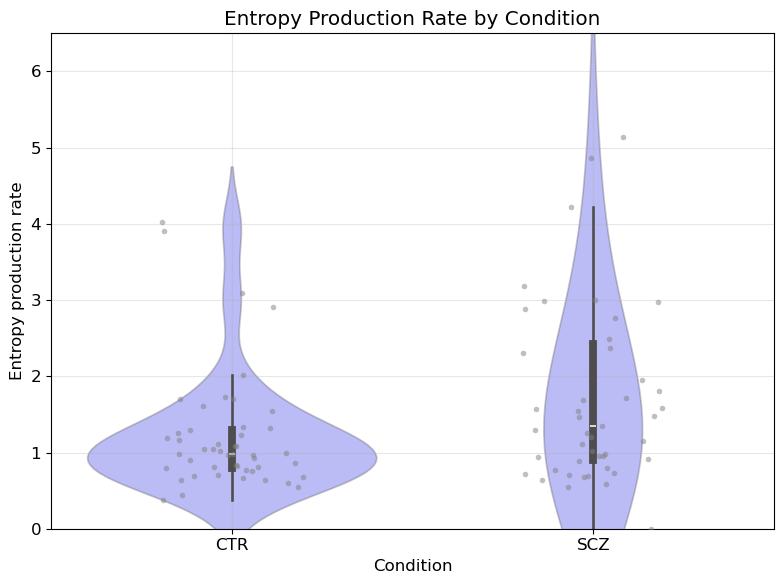

In [549]:

#  actual data
data = pd.DataFrame({
    'Condition': ['CTR']*48 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

# Create the figure
plt.figure(figsize=(8, 6))

# Create violin plot
sb.violinplot(data=data, 
               x='Condition', 
               y='Entropy_production_rate',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sb.stripplot(data=data,
             x='Condition',
             y='Entropy_production_rate',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Customize the plot
plt.title('Entropy Production Rate by Condition')
plt.xlabel('Condition')
plt.ylabel('Entropy production rate')
plt.ylim(0, 6.5)
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

plt.show()

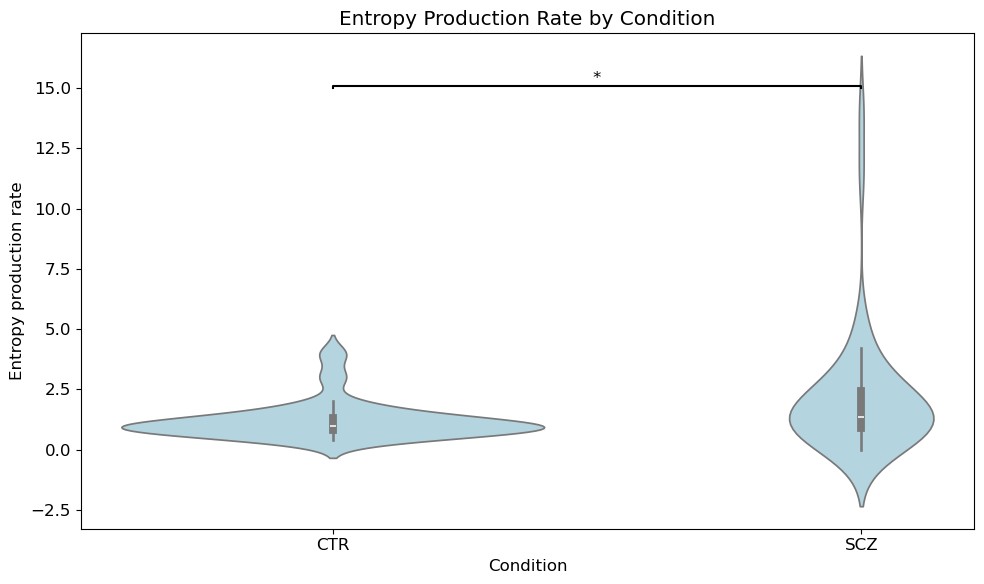

In [550]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Assuming your data is stored in a DataFrame called 'df' with columns 'Condition' and 'Entropy_production_rate'
# If not, adjust the code accordingly

data = pd.DataFrame({
    'Condition': ['CTR']*48 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

def add_significance_bar(ax, data, x1, x2, y, h, p_value):
    """
    Add significance bar to the plot
    
    Parameters:
    -----------
    ax : matplotlib axes object
    data : pandas DataFrame
    x1, x2 : str
        Names of conditions to compare
    y : float
        Height at which to draw the bar
    h : float
        Height of the vertical lines
    p_value : float
        P-value to determine number of asterisks
    """
    # Convert p-value to significance stars
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'
    
    # Get x coordinates
    x1_coord = 0  # Position for 'CTR'
    x2_coord = 1  # Position for 'SCZ'
    
    # Plot the bar
    ax.plot([x1_coord, x1_coord, x2_coord, x2_coord], [y, y+h, y+h, y], 'k-', linewidth=1.5)
    
    # Add star annotation
    ax.text((x1_coord + x2_coord) * 0.5, y+h, star_string,
            ha='center', va='bottom', fontsize=12)

# Example usage:
# First create your violin plot
plt.figure(figsize=(10, 6))
ax = sns.violinplot(x='Condition', y='Entropy_production_rate', data=data,
                    inner='box', color='lightblue')

# Perform statistical test

ctr_data = EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'] 
scz_data = EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR']
stat, p_value = stats.mannwhitneyu(ctr_data, scz_data)

# Add significance bar
# Set y and h based on your data's range
max_val = scz_data.max()
y = max_val + 1  # Adjust these values based on your plot
h = 0.1
add_significance_bar(ax, data, 'CTR', 'SCZ', y, h, p_value)

# Customize plot
plt.title('Entropy Production Rate by Condition')
plt.ylabel('Entropy production rate')
plt.tight_layout()

# Show plot
plt.show()

## Statistical significance test 

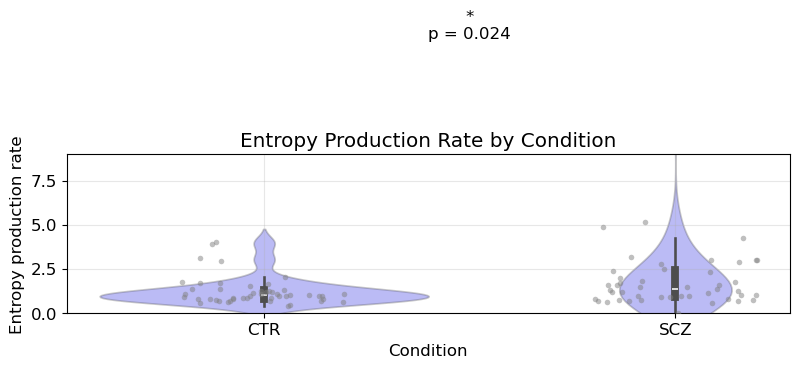


Statistical Test Results:
Mann-Whitney U test statistic: 825.00
p-value: 0.024
statistically significant difference between the distributions of the two groups


In [551]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Create sample data (replace with your actual data)
data = pd.DataFrame({
    'Condition': ['CTR']*48 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})

# Perform statistical test
ctr_data = data[data['Condition'] == 'CTR']['Entropy_production_rate']
scz_data = data[data['Condition'] == 'SCZ']['Entropy_production_rate']

# Perform Mann-Whitney U test (non-parametric test for independent samples)
statistic, p_value = stats.mannwhitneyu(ctr_data, scz_data, alternative='two-sided')

# Create the figure
plt.figure(figsize=(8, 6))

# Create violin plot
sns.violinplot(data=data, 
               x='Condition', 
               y='Entropy_production_rate',
               color='blue',
               alpha=0.3)

# Add strip plot (individual points)
sns.stripplot(data=data,
             x='Condition',
             y='Entropy_production_rate',
             color='gray',
             alpha=0.5,
             jitter=0.2,
             size=4)

# Add significance bar
def add_stat_annotation(p_value):
    # Define the significance level markers
    if p_value < 0.001:
        star_string = '***'
    elif p_value < 0.01:
        star_string = '**'
    elif p_value < 0.05:
        star_string = '*'
    else:
        star_string = 'ns'
    
    # Get y coordinates for the bar
    y_max = data['Entropy_production_rate'].max()
    bar_height = y_max + 1.3
    
    # Plot the significance bar
    x1, x2 = 0, 1  # x-coordinates for CTR and SCZ
    bar_height_diff = 0.1
    
    plt.plot([x1, x1, x2, x2], 
            [bar_height, bar_height + bar_height_diff, bar_height + bar_height_diff, bar_height],
            'k-', linewidth=1.5)
    
    # Add star annotation
    plt.text((x1 + x2) * 0.5, bar_height + bar_height_diff,
            f'{star_string}\np = {p_value:.3f}',
            ha='center', va='bottom')

# Add the significance annotation
add_stat_annotation(p_value)

# Customize the plot
plt.title('Entropy Production Rate by Condition')
plt.xlabel('Condition')
plt.ylabel('Entropy production rate')
plt.ylim(0, 9)  # Adjust the upper limit if needed to show the significance bar
plt.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()
plt.show()

# Print statistical test results
print(f'\nStatistical Test Results:')
print(f'Mann-Whitney U test statistic: {statistic:.2f}')
print(f'p-value: {p_value:.3f}')
if p_value <= 0.05:
    print("statistically significant difference between the distributions of the two groups")
else: 
    print("NO statistically significant difference between the distributions of the two groups")

#plt.savefig(os.path.join(res_dir, f'entropy_prod_rate_stat_test_{lim_FC}.eps'), format='eps')

## ?? What is this for ??

/tmp/ipykernel_5156/1476152158.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


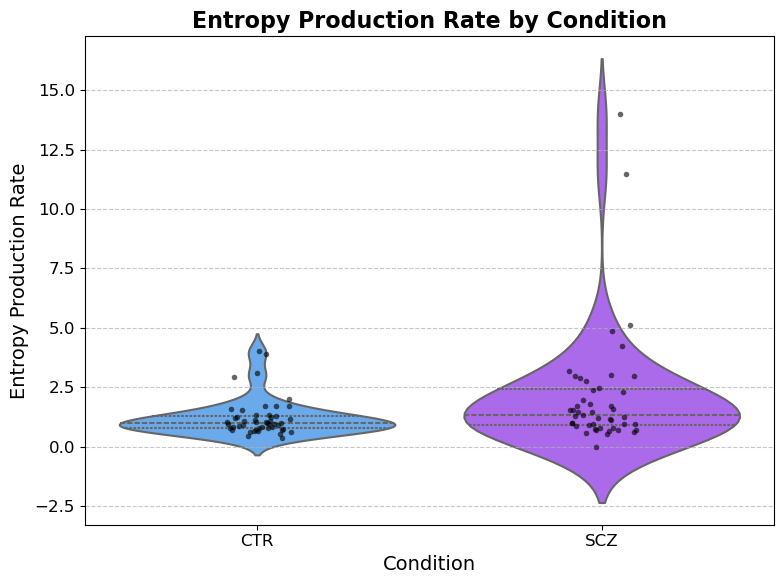

In [552]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example data

data = pd.DataFrame({
    'Condition': ['CTR']*48 + ['SCZ']*47,
    'Entropy_production_rate': np.concatenate([
        EPR_df[EPR_df['sleep stage'] == 'CTR']['EPR'].tolist(),
        EPR_df[EPR_df['sleep stage'] == 'SCZ']['EPR'].tolist()
    ])
})



# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(
    x="Condition",
    y="Entropy_production_rate",
    data=data,
    palette="cool",
    inner="quartile",
    linewidth=1.5
)

# Add individual data points
sns.stripplot(
    x="Condition",
    y="Entropy_production_rate",
    data=data,
    color="black",
    size=4,
    alpha=0.6,
    jitter=True
)

# Customize the plot
plt.title("Entropy Production Rate by Condition", fontsize=16, fontweight="bold")
plt.xlabel("Condition", fontsize=14)
plt.ylabel("Entropy Production Rate", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle="--", alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()